# Práctica de Machine Learning. Dataset de Airbnb


## 0.- Preliminares

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns


# Config
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None) 

### 0.1.- Identificación del tipo de problema

Como la variable objetivo es el precio del aquiler del apartamento y se trata de una variable continua, como una primera aproximación se tratará como un problema de regresión.

Scripts / Funciones de ayuda

In [2]:
def test_na_by_column(df):
    total = len(df)
    result = []
    for dfColumn in df.columns:
        result = result + [[dfColumn,(df[dfColumn].isna().sum()/total)*100 ]]
    
    print(sorted(result, key = lambda x: x[1], reverse=True))      
    
def scale_columns(df, list_columns):
    sum = 0
    for columnName in list_columns:
        sum = sum + df[columnName] * 100 / 10
    return sum / len(list_columns)

def var_important_analisys(df):
    data = df.values
    y = data[:,0:1]
    X = data[:,1:]

    feature_names = df.columns[1:]

    mi = mutual_info_regression(X, y)
    mi /= np.max(mi)

    # Tamaño de la gráfica
    f = plt.figure()
    f.set_figwidth(40)
    f.set_figheight(10)

    plt.subplot(1,2,2)
    plt.bar(range(X.shape[1]),mi, align="center")
    plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
    plt.xlabel('Features')
    plt.ylabel('Ranking')
    plt.title('Mutual information score')

    plt.show()
    
def graph_corr(dataf, column):
    # Compute the correlation matrix
    corr = np.abs(dataf.drop([column], axis=1).corr())

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
                linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

    plt.show()
    
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

Carga del dataset

In [3]:
full_df = pd.read_csv('./data/airbnb-listings.csv', sep=';', decimal='.')

### 0.2.- Limpieza de datos previa a la división de datos

A pesar de no ser un práctica recomendada antes de realizar la división entre train y test, se realiza una limpieza de los datos por los siguientes motivos:
   - El estudio se va a realizar sobre la ciudad de Madrid con lo cual se pueden eliminar las filas de otras ciudades.
   - Las columnas cuyo contenido es una URL no se van a ser relevantes para el modelo.
   - Eliminación de ID's internos de Airbnb
   - Eliminación de columnas/campos vacíos.

In [4]:
full_df = full_df[full_df.City == 'Madrid']

In [5]:
full_df = full_df.drop(['Listing Url', 'Host Thumbnail Url', 'Host Picture Url', 'Host URL', 'Picture Url', 'Medium Url', 'Thumbnail Url', 'XL Picture Url'], axis=1)

In [6]:
full_df = full_df.drop(['ID', 'Scrape ID', 'Host ID'], axis=1)

In [7]:
empty_cols = [col for col in full_df.columns if full_df[col].isnull().all()]
print("Columnas que se van a eliminar: ", empty_cols)
full_df = full_df.drop(empty_cols, axis=1)

Columnas que se van a eliminar:  ['Host Acceptance Rate', 'Has Availability', 'Jurisdiction Names']


In [8]:
full_df.shape

(13207, 75)

## 1.- Preparación de los datos

### 1.1.- División de los datos en Train y Test

In [9]:
df_train, df_test = train_test_split(full_df, test_size=.25, shuffle=True, random_state=0)

In [10]:
print(f'Dimensiones del dataset de training: {df_train.shape}')
print(f'Dimensiones del dataset de test: {df_test.shape}')

# Guardamos
df_train.to_csv('./data/train.csv', sep=';', decimal='.', index=False)
df_test.to_csv('./data/test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (9905, 75)
Dimensiones del dataset de test: (3302, 75)


### <span style="color: red">Elección del entorno</span>

In [11]:
# Valores posibles "test" y "train"
ENVIRONMENT = "train"

In [12]:
# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 
if ENVIRONMENT == 'test':
    df = pd.read_csv( './data/test.csv', sep=';', decimal='.')
else: 
    df = pd.read_csv('./data/train.csv', sep=';', decimal='.')

## 2.- Análisis exploratorio

### 2.2.- Limpieza de los datos

In [13]:
df.head()

,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,2017-04-08,SOL-Top Located Private Room,This cosy room is the perfect place to stay! L...,NaN,This cosy room is the perfect place to stay! L...,none,Es el lugar de Madrid desde donde realizar tod...,NaN,NaN,Están a tu disposición el baño la cocina y el ...,"En función de sus preferencias, podemos recome...","Respetar el descanso de los vecinos, a partir ...",Mamen-Helion,2014-11-24,"Madrid, Community of Madrid, Spain",NaN,within an hour,100.0,NaN,2.0,2.0,"email,phone,reviews","Madrid, Comunidad de Madrid 28013, Spain",NaN,Sol,Centro,Madrid,Comunidad de Madrid,28013,Madrid,"Madrid, Spain",ES,Spain,40.416602,-3.703235,House,Private room,2,1.0,1.0,1.0,Real Bed,"TV,Wireless Internet,Kitchen,Elevator in build...",NaN,40.0,NaN,NaN,NaN,10.0,1,10,2,1125,4 days ago,9,23,45,111,2017-04-08,18,2016-04-19,2016-12-11,96.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,flexible,2.0,1.52,"40.416602094776714, -3.703235393142762","Host Has Profile Pic,Requires License"
1,2017-04-08,Habitación privada buena finca. Cama individual.,Casa en buena finca. Luminosa y acogedora. Ase...,El barrio es muy tranquilo y bien comunicado. ...,Casa en buena finca. Luminosa y acogedora. Ase...,none,Barrio tranquilo con todo tipo de servicios. B...,NaN,Metro y numerosas líneas de autobuses para lle...,Pueden acceder a toda la casa.,NaN,NaN,Rocío,2010-01-14,"Madrid, Madrid, Spain",NaN,within an hour,100.0,Castillejos,2.0,2.0,"email,phone,reviews","Castillejos, Madrid, Comunidad de Madrid 28020...",Castillejos,Castillejos,Tetuán,Madrid,Comunidad de Madrid,28020,Madrid,"Madrid, Spain",ES,Spain,40.462501,-3.692039,House,Private room,1,1.0,1.0,1.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,30.0,NaN,NaN,NaN,NaN,1,0,1,16,4 weeks ago,30,60,90,365,2017-04-08,1,2017-03-05,2017-03-05,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,flexible,2.0,0.86,"40.46250142537208, -3.692038718034643","Host Has Profile Pic,Requires License"
2,2017-04-08,Piso Superior Grande - Top Floor West Facing L...,Este es un gran apartamento de estudio en la p...,Nice west view with great afternoon light over...,Este es un gran apartamento de estudio en la p...,none,NaN,NaN,NaN,NaN,NaN,"- Quiet, shoes off house.",Steve,2009-06-02,"Berkeley, California, United States","We're a low key, easygoing couple. When we tr...",within a few hours,100.0,Pacific Heights,4.0,4.0,"email,phone,facebook,reviews,kba","Madrid, Comunidad de Madrid 28035, Spain",NaN,Peñagrande,Fuencarral - El Pardo,Madrid,Comunidad de Madrid,28035,Madrid,"Madrid, Spain",ES,Spain,40.477100,-3.727888,Apartment,Entire home/apt,5,1.0,0.0,3.0,Real Bed,"Wireless Internet,Pool,Kitchen,Pets allowed,He...",NaN,59.0,NaN,NaN,500.0,65.0,2,9,6,365,today,12,17,47,322,2017-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,3.0,NaN,"40.47709972420583, -3.7278881500113736","Host Has Profile Pic,Host Identity Verified,Re..."
3,2017-04-08,Cool and comfy room in a quiet hood!!,The loft is full

Los campos siguientes se considera que no aportan información para el estudio:
   - Name
   - Summary
   - Space
   - Description
   - House Rules
   - Interaction
   - Host About
   - Notes
   - Host Name
   - Neighborhood Overview
   - Access
   - License
   

In [14]:
df = df.drop(['Name', 'Summary', 'Space', 'Description', 'House Rules', 'Interaction', 'Host About', 'Notes', 'Host Name', 'Access', 'Neighborhood Overview', 'License'], axis=1)

Se sospecha que ciertos campos pueden contener valores iguales.

In [15]:
df['Smart Location'].value_counts()

Madrid, Spain     9892
Madrid , Spain      13
Name: Smart Location, dtype: int64

In [16]:
df['Last Scraped'].value_counts()

2017-04-08    9905
Name: Last Scraped, dtype: int64

In [17]:
df['Experiences Offered'].value_counts()

none    9905
Name: Experiences Offered, dtype: int64

In [18]:
df['Calendar last Scraped'].value_counts()

2017-04-08    7238
2017-04-07    2667
Name: Calendar last Scraped, dtype: int64

In [19]:
df = df.drop(['Smart Location','Last Scraped', 'Calendar last Scraped', 'Experiences Offered'], axis=1)

Los campos "Market, State, Host Location, City, Country Code, Country" hacen referencia a la ciudad, como el estudio es sobre "Madrid" no aportan información al modelo.

In [20]:
df = df.drop(['Market', 'State', 'Host Location', 'City', 'Country Code', 'Country'], axis=1)

In [21]:
df.head().T

,0,1,2,3,4
Transit,NaN,Metro y numerosas líneas de autobuses para lle...,NaN,Nearest city train (Cercanías) train station i...,NaN
Host Since,2014-11-24,2010-01-14,2009-06-02,2014-07-30,2016-09-21
Host Response Time,within an hour,within an hour,within a few hours,within a day,NaN
Host Response Rate,100.0,100.0,100.0,50.0,NaN
Host Neighbourhood,NaN,Castillejos,Pacific Heights,Aluche,Palacio
Host Listings Count,2.0,2.0,4.0,1.0,5.0
Host Total Listings Count,2.0,2.0,4.0,1.0,5.0
Host Verifications,"email,phone,reviews","email,phone,reviews","email,phone,facebook,reviews,kba","email,phone,reviews,jumio","email,phone,google,reviews"
Street,"Madrid, Comunidad de Madrid 28013, Spain","Castillejos, Madrid, Comunidad de Madrid 28020...","Madrid, Comunidad de Madrid 28035, Spain","Aluche, Madrid, Comunidad de Madrid 28054, Spain","Palacio, Madrid, Comunidad de Madrid 28013, Spain"
Neighbourhood,NaN,Castillejos,NaN,Aluche,Palacio


Se decide eliminar la columna "Transit" que se usa para indicar el Transporte cercano que podría afectar en el precio, pero al ser un campo de texto libre es muy dificil de sacar conclusiones sobre el mismo.  

In [22]:
df = df.drop(['Transit'], axis=1)

Otra variables / columnas que se interpretan que no tienen relevancia son las relativas al anfitrion.

In [23]:
df = df.drop(['Host Since', 'Host Response Rate', 'Host Response Time', 'Host Neighbourhood', 'Host Response Rate', 'Host Listings Count', 'Host Total Listings Count', 'Host Verifications', 'Calculated host listings count'], axis=1)

La variable Geolocation es la concatenación de Latitude y Longitude.

In [24]:
df = df.drop(['Geolocation'], axis=1)

La variable Neighbourhood contiene información equivalente a la varibale Neighbourhood Cleansed, con lo cual se decide utilizar esta última.

In [25]:
df = df.drop(['Neighbourhood'], axis=1)

Revisando los valores de las variables de texto para ver si se puede realizar algún tipo de codificación lógica.

In [26]:
print('Nº de valores distintos en: ')
textColumns = df.select_dtypes(include = 'object').columns
for dfVar in textColumns:
    print(f'\t {dfVar}: ', len(df[dfVar].value_counts()))
    

Nº de valores distintos en: 
	 Street:  604
	 Neighbourhood Cleansed:  125
	 Neighbourhood Group Cleansed:  21
	 Zipcode:  72
	 Property Type:  19
	 Room Type:  3
	 Bed Type:  5
	 Amenities:  8495
	 Calendar Updated:  54
	 First Review:  1494
	 Last Review:  656
	 Cancellation Policy:  5
	 Features:  53


El campo de texto Street, se observa que tiene muchas variantes y además su información está muy relacionada con el barrio. 

In [27]:
df = df.drop(['Street'], axis=1)

La bariable "Calendar Updated" hace referencia a la ultima actualizacion de la disponiblidad y no se considera relevante para el modelo

In [28]:
df = df.drop(['Calendar Updated'], axis=1)

Los campos referentes a la disponiblidad o Availability no se considera que puedan afectar al precio

In [29]:
# df = df.drop(['Availability 30', 'Availability 60', 'Availability 90', 'Availability 365'], axis=1)

Fecha de la primera y ultima review no se consideran relevantes

In [30]:
df = df.drop(['First Review', 'Last Review'], axis=1)

In [31]:
df.head().T

,0,1,2,3,4
Neighbourhood Cleansed,Sol,Castillejos,Peñagrande,Cuatro Vientos,Palacio
Neighbourhood Group Cleansed,Centro,Tetuán,Fuencarral - El Pardo,Latina,Centro
Zipcode,28013,28020,28035,28054,28013
Latitude,40.416602,40.462501,40.4771,40.3732,40.421012
Longitude,-3.703235,-3.692039,-3.727888,-3.773208,-3.707141
Property Type,House,House,Apartment,Loft,Apartment
Room Type,Private room,Private room,Entire home/apt,Private room,Entire home/apt
Accommodates,2,1,5,1,2
Bathrooms,1.0,1.0,1.0,1.0,1.0
Bedrooms,1.0,1.0,0.0,1.0,1.0


In [32]:
df.shape

(9905, 38)

### 2.3.- Missing values

Ver el porcentaje de NA por columna

In [33]:
test_na_by_column(df)

[['Square Feet', 96.12317011610297], ['Monthly Price', 74.46744068652195], ['Weekly Price', 74.14437152953055], ['Security Deposit', 57.37506309944472], ['Cleaning Fee', 41.01968702675416], ['Review Scores Location', 22.110045431600202], ['Review Scores Value', 22.110045431600202], ['Review Scores Checkin', 22.089853609288237], ['Review Scores Accuracy', 22.00908632004038], ['Review Scores Communication', 21.968702675416456], ['Review Scores Cleanliness', 21.94851085310449], ['Review Scores Rating', 21.847551741544674], ['Reviews per Month', 20.918727915194346], ['Zipcode', 3.2912670368500754], ['Amenities', 0.7874810701665825], ['Beds', 0.4543160020191822], ['Bathrooms', 0.4139323573952549], ['Bedrooms', 0.1817264008076729], ['Price', 0.05047955577990913], ['Neighbourhood Cleansed', 0.0], ['Neighbourhood Group Cleansed', 0.0], ['Latitude', 0.0], ['Longitude', 0.0], ['Property Type', 0.0], ['Room Type', 0.0], ['Accommodates', 0.0], ['Bed Type', 0.0], ['Guests Included', 0.0], ['Extra P

Aunque el campo "Square Feet" se sopecha que puede ser importante para el modelo que estamos estudiando, contiene más de un 95% de NAN. Pasa algo similar con las variables Monthly Price, Weekly Price. Se eliminan.

In [34]:
# df = df.drop(['Square Feet', 'Monthly Price', 'Weekly Price'], axis=1)
df = df.drop(['Square Feet'], axis=1)

Como primera medida se decide eliminar las filas con NAN en las columnas cuya cantidad de NAN es inferior al 1%. Son pocos registros y tendrá poco impacto.

In [35]:
total = len(df)
result = []
for dfColumn in df.columns:
    percentNAN = df[dfColumn].isna().sum()/total
    if 0.0 < percentNAN < 0.01:
        result = result + [[dfColumn,df[dfColumn].isna().sum()/total]]
df[[row[0] for row in result]].isna().sum()

Bathrooms    41
Bedrooms     18
Beds         45
Amenities    78
Price         5
dtype: int64

In [36]:
rowsWIthLowNa = [ 'Bathrooms', 'Bedrooms', 'Amenities', 'Beds', 'Price' ]
for dfVar in rowsWIthLowNa:
    df = df[df[dfVar].notna()]

In [37]:
df.shape

(9773, 37)

Se considera que los valores NA de las columnas 'Security Deposit' y 'Cleaning Fee' serían equivalentes a 0, o lo que es lo mismo, no tienen Fianza ni Tarifa de limpieza.

In [38]:
df['Security Deposit'] = df['Security Deposit'].fillna(0)
df['Cleaning Fee'] = df['Cleaning Fee'].fillna(0)

El campo Zipcode se van a rellenar con la moda ya que tiene relacion con el barrio:

In [39]:
groups = df.groupby('Neighbourhood Cleansed')

mode_zipcode = groups['Zipcode'].transform(lambda x: x.mode()[0])    
df['Zipcode'] = df['Zipcode'].fillna(mode_zipcode)

In [40]:
df.isna().sum()

Neighbourhood Cleansed             0
Neighbourhood Group Cleansed       0
Zipcode                            0
Latitude                           0
Longitude                          0
Property Type                      0
Room Type                          0
Accommodates                       0
Bathrooms                          0
Bedrooms                           0
Beds                               0
Bed Type                           0
Amenities                          0
Price                              0
Weekly Price                    7254
Monthly Price                   7283
Security Deposit                   0
Cleaning Fee                       0
Guests Included                    0
Extra People                       0
Minimum Nights                     0
Maximum Nights                     0
Availability 30                    0
Availability 60                    0
Availability 90                    0
Availability 365                   0
Number of Reviews                  0
R

Se hace una estimacion de lo que saldría el precio por día y se rellena con la media.

In [41]:
# df['day_price'] = np.where(df['Weekly Price'].isna(), df['Monthly Price'] / 30, df['Weekly Price'] / 7)
df['day_price_by_week'] = df['Weekly Price'] / 7
df['day_price_by_month'] = df['Monthly Price'] / 30
# df = df.drop(['Weekly Price','Monthly Price' ], axis=1)


In [42]:
# df['day_price'] = df['day_price'].fillna(df['day_price'].mean())
df['day_price_by_week'] = df['day_price_by_week'].fillna(df['Price'].mean())
df['day_price_by_month'] = df['day_price_by_month'].fillna(df['Price'].mean())



In [43]:
df = df.drop(['Monthly Price', 'Weekly Price'], axis=1)

Las variables "Review..." Se rellenan los NA con la media de cada columna.

In [44]:
columns_to_fill = ['Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value', 'Reviews per Month']
 
for varColumn in columns_to_fill:
    df[varColumn] = df[varColumn].fillna(df[varColumn].mean())

In [45]:
df.isna().sum()

Neighbourhood Cleansed          0
Neighbourhood Group Cleansed    0
Zipcode                         0
Latitude                        0
Longitude                       0
Property Type                   0
Room Type                       0
Accommodates                    0
Bathrooms                       0
Bedrooms                        0
Beds                            0
Bed Type                        0
Amenities                       0
Price                           0
Security Deposit                0
Cleaning Fee                    0
Guests Included                 0
Extra People                    0
Minimum Nights                  0
Maximum Nights                  0
Availability 30                 0
Availability 60                 0
Availability 90                 0
Availability 365                0
Number of Reviews               0
Review Scores Rating            0
Review Scores Accuracy          0
Review Scores Cleanliness       0
Review Scores Checkin           0
Review Scores 

### 2.4.- Transformación de variables

Las variables Amenities y Features, se decide transformaralas con el número de elementos que contienen

In [46]:
df['Amenities'] = df['Amenities'].str.count(',') + 1

In [47]:
df['Features'] = df['Features'].str.count(',') + 1

### 2.2.- Outliers

In [48]:
df.describe()

,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Amenities,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per Month,Features,day_price_by_week,day_price_by_month
count,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000,9773.000000
mean,40.420602,-3.696988,3.175586,1.249667,1.292029,1.970326,14.416147,65.600941,78.360585,17.554896,1.566152,7.368055,2.897882,894.477642,8.587844,22.645145,39.768034,204.673591,23.065282,91.620209,9.409014,9.329634,9.617889,9.640376,9.547155,9.214781,1.922022,3.766397,62.379056,60.375916
std,0.020004,0.023191,1.955991,0.597898,0.826331,1.480374,4.604147,55.304399,114.641479,24.723476,1.059839,10.676374,7.514266,2327.218097,8.980512,19.324145,29.109795,126.891945,38.822977,8.039077,0.825453,0.880769,0.712691,0.676305,0.667214,0.845598,1.674423,1.028238,15.010366,19.186433
min,40.332908,-3.835498,1.000000,0.000000,0.000000,1.000000,1.000000,9.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.020000,1.000000,10.000000,8.333333
25%,40.410104,-3.707706,2.000000,1.000000,1.000000,1.000000,11.000000,31.000000,0.000000,0.000000,1.000000,0.000000,1.000000,365.000000,0.000000,5.000000,13.000000,82.000000,1.000000,90.000000,9.000000,9.000000,9.617889,9.640376,9.000000,9.000000,0.650000,3.000000,65.600941,65.600941
50%,40.418485,-3.701438,2.000000,1.000000,1.000000,1.000000,14.000000,53.000000,0.000000,10.000000,1.000000,0.000000,2.000000,1125.000000,6.000000,20.000000,38.000000,247.000000,7.000000,91.620209,9.409014,9.329634,10.000000,10.000000,10.000000,9.214781,1.922022,4.000000,65.600941,65.600941
75%,40.427675,-3.693580,4.000000,1.000000,2.000000,2.000000,17.000000,80.000000,150.000000,30.000000,2.000000,14.000000,3.000000,1125.000000,13.000000,37.000000,64.000000,320.000000,27.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.330000,4.000000,65.600941,65.600941
max,40.514125,-3.573613,16.000000,8.000000,10.000000,16.000000,34.000000,875.000000,990.000000,500.000000,16.000000,276.000000,365.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,446.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,13.900000,8.000000,142.714286,833.333333


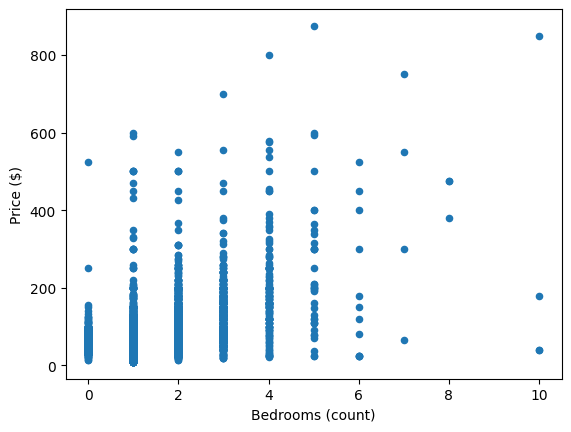

In [49]:
df.plot(kind = 'scatter',x='Bedrooms',y = 'Price')
plt.xlabel('Bedrooms (count)')
plt.ylabel('Price ($)')
plt.show()

Se eliminan los apartamentos que contengan mas de 8 habitaciones y un precio menor de 300

In [50]:
df = df.drop(df[(df['Bedrooms'] > 7) & (df['Price'] < 300)].index)

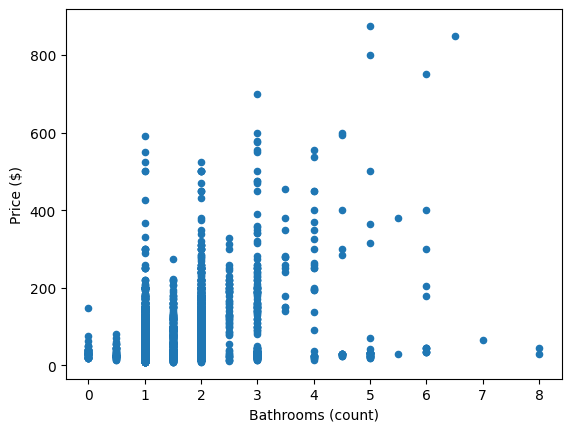

In [51]:
df.plot(kind = 'scatter',x='Bathrooms',y = 'Price')
plt.xlabel('Bathrooms (count)')
plt.ylabel('Price ($)')
plt.show()

Se elimina los apartamentos con más de 7 baños y un precio indeferior a 200.

In [52]:
df = df.drop(df[(df['Bathrooms'] > 7) & (df['Price'] < 200)].index)

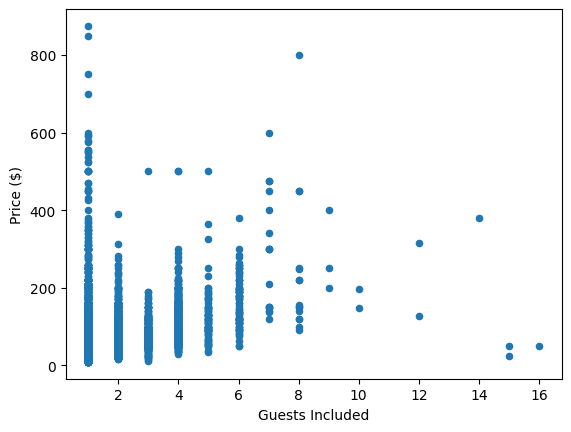

In [53]:
df.plot(kind = 'scatter',x='Guests Included',y = 'Price')
plt.xlabel('Guests Included')
plt.ylabel('Price ($)')
plt.show()

No se decide eliminar los precios bajos con muchas personas porque se piensa que se podría tratar de Albergues.

<AxesSubplot: title={'center': 'Price'}, xlabel='Room Type'>

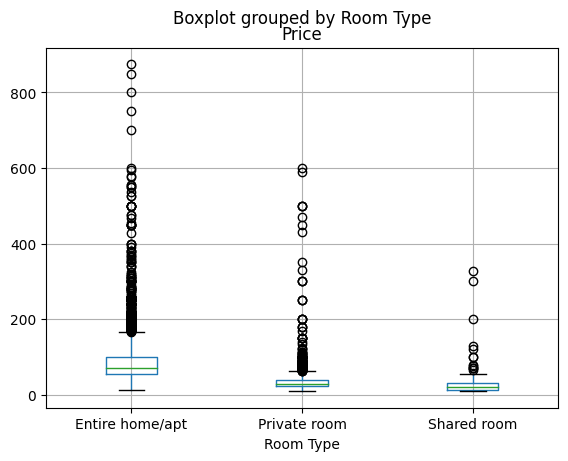

In [54]:
df.boxplot(by='Room Type',column = 'Price')

### 2.4.- Codificación de variables

In [55]:
df.dtypes

Neighbourhood Cleansed           object
Neighbourhood Group Cleansed     object
Zipcode                          object
Latitude                        float64
Longitude                       float64
Property Type                    object
Room Type                        object
Accommodates                      int64
Bathrooms                       float64
Bedrooms                        float64
Beds                            float64
Bed Type                         object
Amenities                         int64
Price                           float64
Security Deposit                float64
Cleaning Fee                    float64
Guests Included                   int64
Extra People                      int64
Minimum Nights                    int64
Maximum Nights                    int64
Availability 30                   int64
Availability 60                   int64
Availability 90                   int64
Availability 365                  int64
Number of Reviews                 int64


In [56]:
df['Cancellation Policy'].value_counts()

strict             3721
flexible           3129
moderate           2912
super_strict_60       4
super_strict_30       2
Name: Cancellation Policy, dtype: int64

In [57]:
df['Bed Type'].value_counts()

Real Bed         9551
Pull-out Sofa     170
Futon              29
Couch              13
Airbed              5
Name: Bed Type, dtype: int64

In [58]:
df['Room Type'].value_counts()

Entire home/apt    5899
Private room       3734
Shared room         135
Name: Room Type, dtype: int64

In [59]:
categorical = ['Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'Zipcode', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy']

mean_map = {}
for c in categorical:
    mean = df.groupby(c)['Price'].mean()
    df[c] = df[c].map(mean)    
    mean_map[c] = mean

In [60]:
df.dtypes

Neighbourhood Cleansed          float64
Neighbourhood Group Cleansed    float64
Zipcode                         float64
Latitude                        float64
Longitude                       float64
Property Type                   float64
Room Type                       float64
Accommodates                      int64
Bathrooms                       float64
Bedrooms                        float64
Beds                            float64
Bed Type                        float64
Amenities                         int64
Price                           float64
Security Deposit                float64
Cleaning Fee                    float64
Guests Included                   int64
Extra People                      int64
Minimum Nights                    int64
Maximum Nights                    int64
Availability 30                   int64
Availability 60                   int64
Availability 90                   int64
Availability 365                  int64
Number of Reviews                 int64


In [61]:
df.isna().sum()

Neighbourhood Cleansed          0
Neighbourhood Group Cleansed    0
Zipcode                         0
Latitude                        0
Longitude                       0
Property Type                   0
Room Type                       0
Accommodates                    0
Bathrooms                       0
Bedrooms                        0
Beds                            0
Bed Type                        0
Amenities                       0
Price                           0
Security Deposit                0
Cleaning Fee                    0
Guests Included                 0
Extra People                    0
Minimum Nights                  0
Maximum Nights                  0
Availability 30                 0
Availability 60                 0
Availability 90                 0
Availability 365                0
Number of Reviews               0
Review Scores Rating            0
Review Scores Accuracy          0
Review Scores Cleanliness       0
Review Scores Checkin           0
Review Scores 

### 2.3.- Correlación

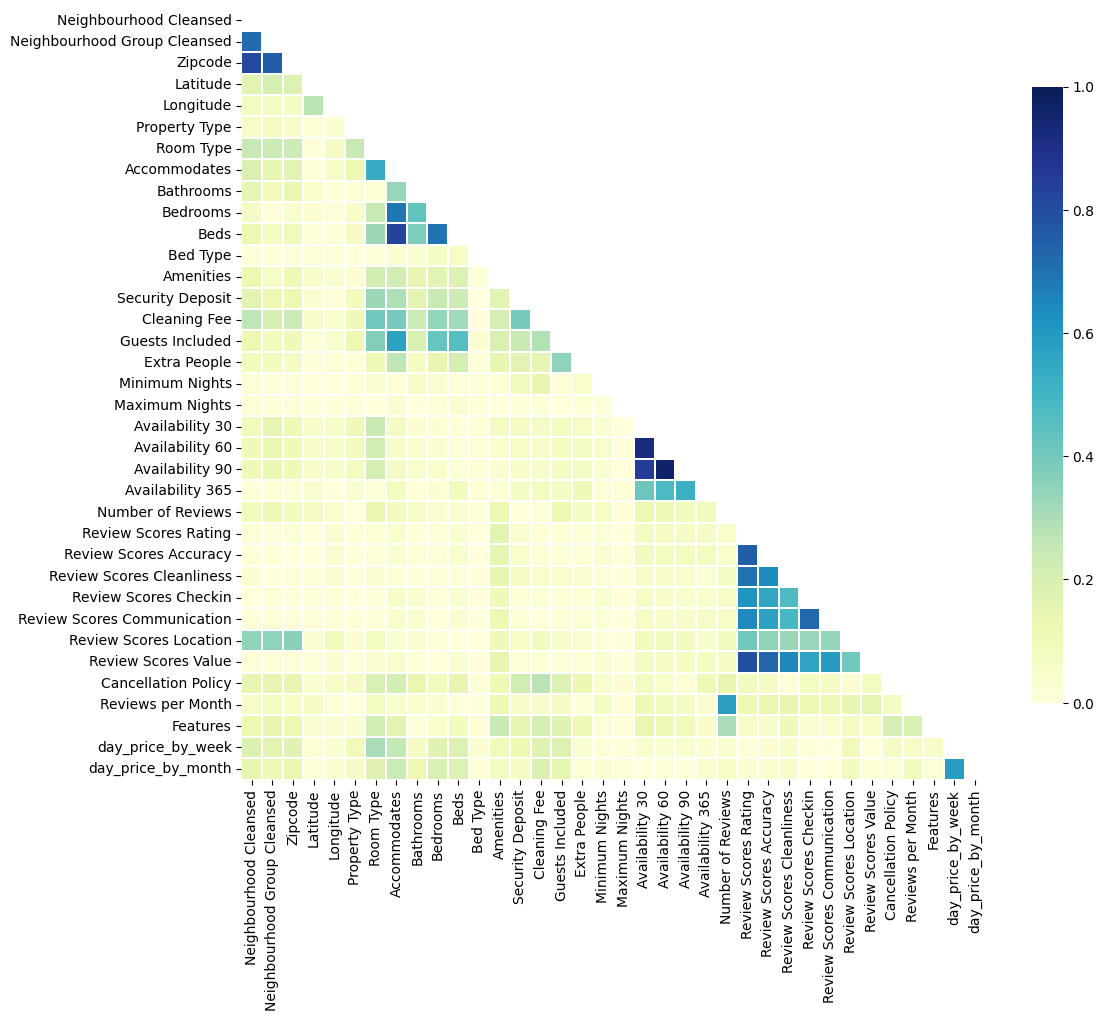

In [62]:
graph_corr(df, 'Price')

Se observan las siguientes relaciones entre variables:
   - Neighbourhood Cleansed, Neighbourhood Group Cleansed, ZipCode -> Todas hacen refencia a la zona.
   - Bathrooms, Bedrooms, Beds, Accommodates -> Determinará la capacidad del apartamento
       - Con Cleaning Fee -> A mayor número de personas, habitaciones y baños mayor será la cuota de limpieza
       - Con Guest Included -> A mayor capacidad más personas incluidas en la reserva
   - Campos Review, los importantes serían "Review Scores Rating" y "Review Scores Accuracy"

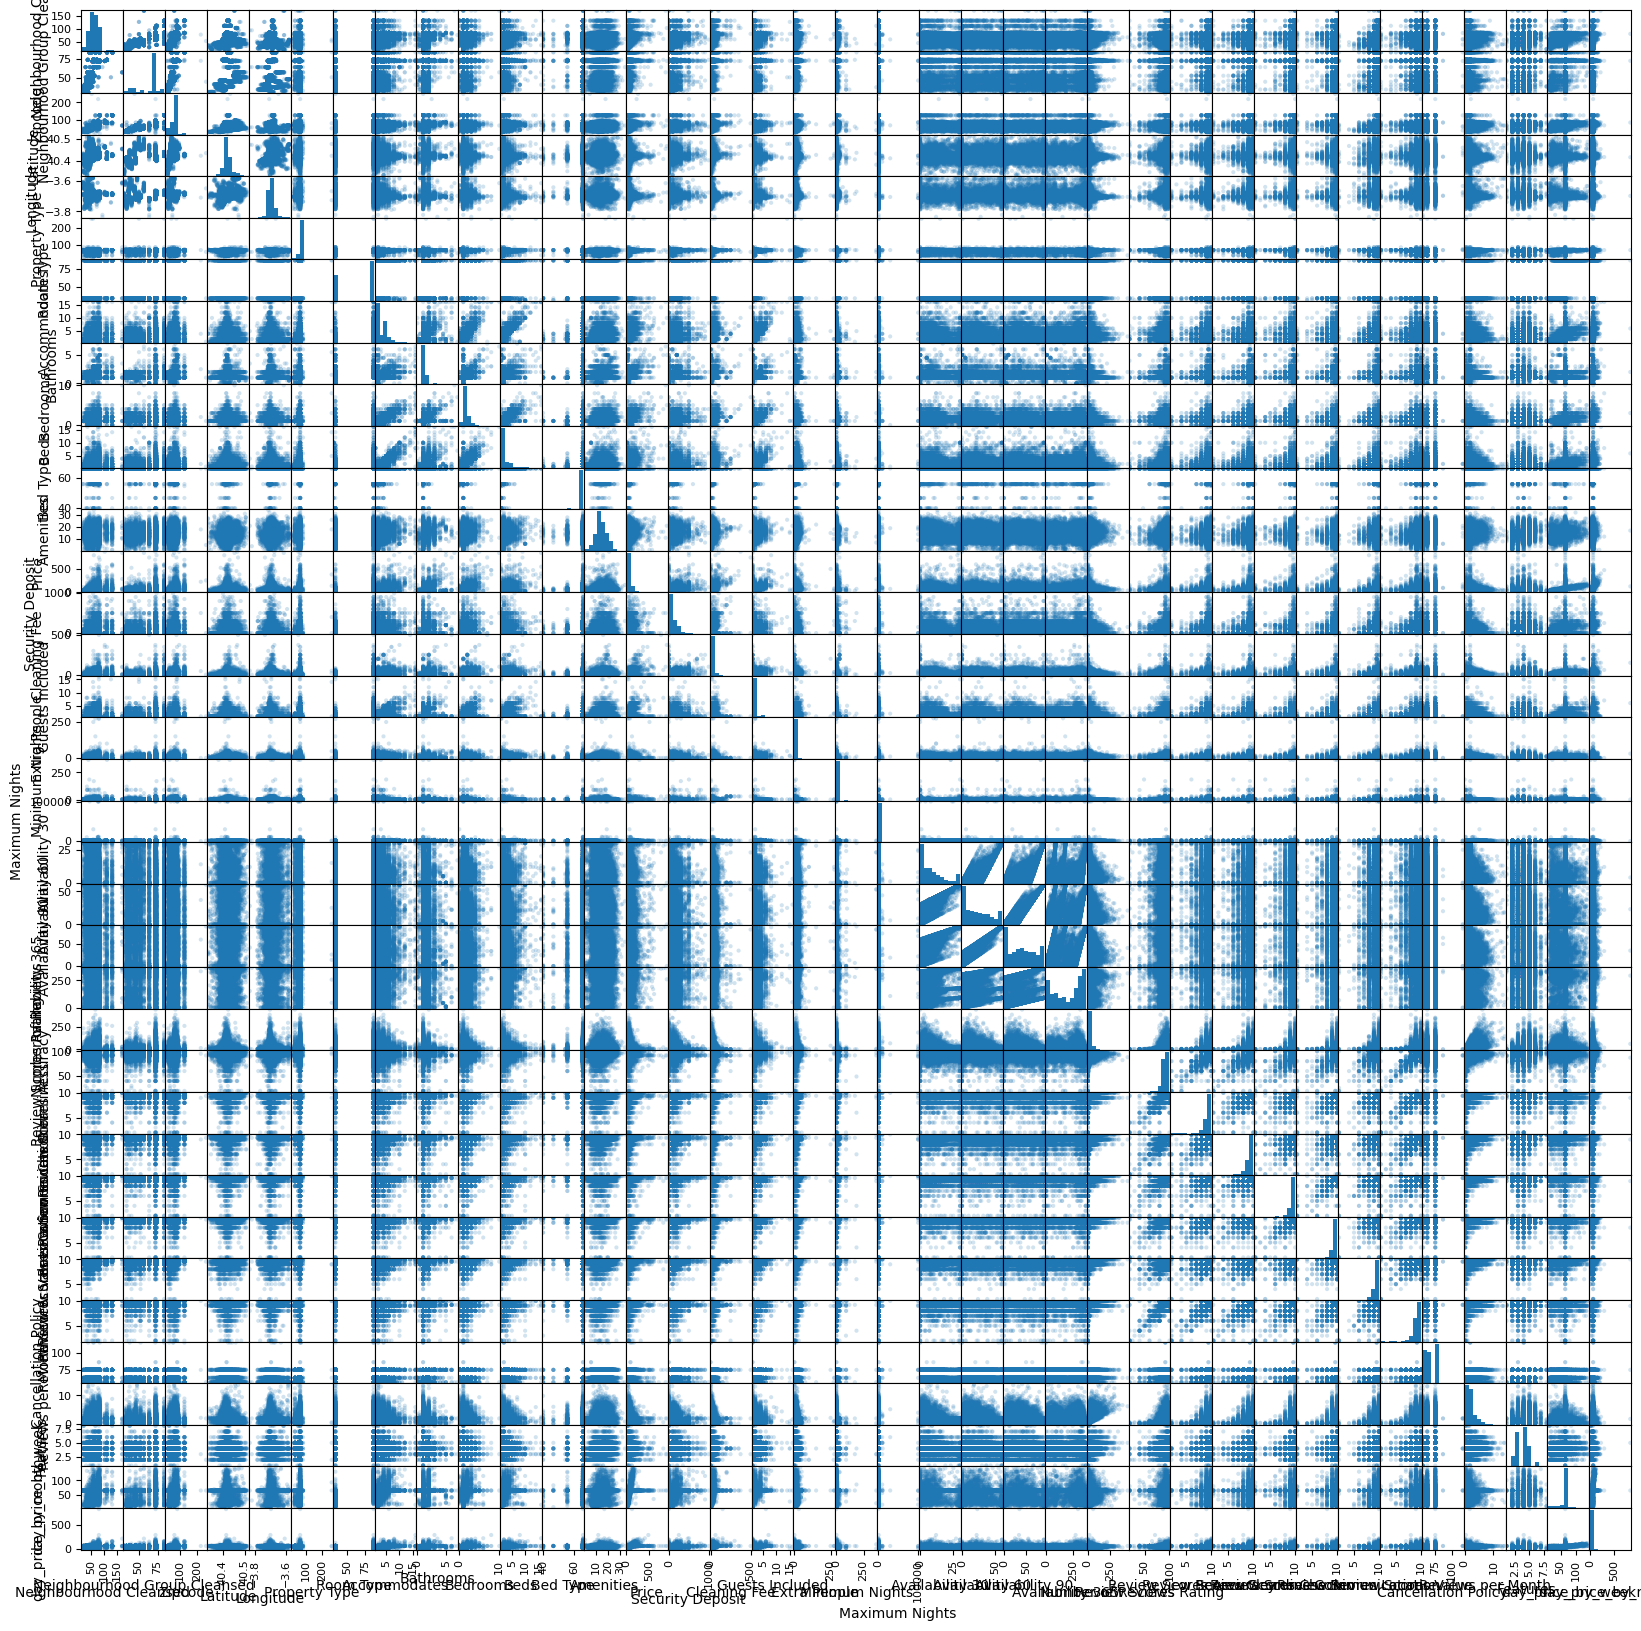

In [63]:
if ENVIRONMENT == 'train':
    pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal = 'hist')
    plt.show()

## 3.- Preprocesamiento

### 3.1.- Ordenación de las variables

In [64]:
# Ordenacion de las columnas
df.columns
priceIndex = df.columns.get_loc("Price")
restIndex = list(range(0, priceIndex)) + list(range(priceIndex+1, len(df.columns)))
df = df.iloc[:, [priceIndex] + restIndex]
df.columns

Index(['Price', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed',
       'Zipcode', 'Latitude', 'Longitude', 'Property Type', 'Room Type',
       'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
       'Amenities', 'Security Deposit', 'Cleaning Fee', 'Guests Included',
       'Extra People', 'Minimum Nights', 'Maximum Nights', 'Availability 30',
       'Availability 60', 'Availability 90', 'Availability 365',
       'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Cancellation Policy', 'Reviews per Month',
       'Features', 'day_price_by_week', 'day_price_by_month'],
      dtype='object')

## 4.- Modelado

In [65]:
df.shape

(9768, 37)


### 4.1.- Cross validation

In [66]:
data = df.values
X = data[:,1:]   # nos quedamos con la 1ª columna, price
y = data[:,0:1]  # nos quedamos con el resto
feature_names = df.columns[1:]

if ENVIRONMENT == 'train':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

    # Escalamos (con los datos de train)
    scaler = preprocessing.StandardScaler().fit(X_train)
    XtrainScaled = scaler.transform(X_train)
    XtestScaled = scaler.transform(X_test)

    print('Datos entrenamiento: ', X_train.shape)
    print('Datos test: ', X_test.shape)

Datos entrenamiento:  (7326, 36)
Datos test:  (2442, 36)


Se aplica Lasso para seleccionar las variables mas y menos relevantes para el modelo

best mean cross-validation score: -1437.907
best parameters: {'alpha': 0.28117686979742307}


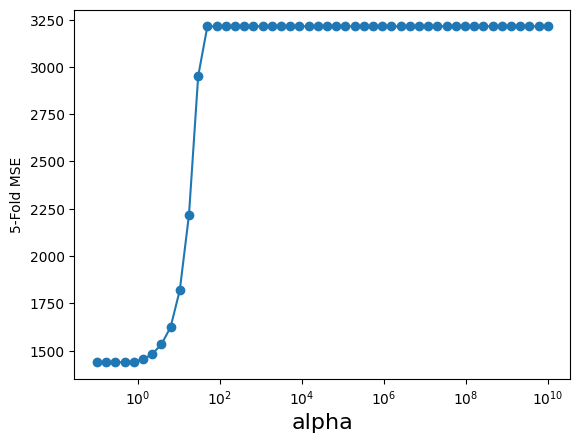

In [67]:
if ENVIRONMENT == 'train':
    alpha_vector = np.logspace(-1,10,50)
    param_grid_lasso = {'alpha': alpha_vector }
    grid_lasso = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid_lasso, cv = 10)
    grid_lasso.fit(XtrainScaled, y_train)
    print("best mean cross-validation score: {:.3f}".format(grid_lasso.best_score_))
    print("best parameters: {}".format(grid_lasso.best_params_))

    #-1 porque es negado
    scores = -1*np.array(grid_lasso.cv_results_['mean_test_score'])
    plt.semilogx(alpha_vector,scores,'-o')
    plt.xlabel('alpha',fontsize=16)
    plt.ylabel('5-Fold MSE')
    plt.show()
    df.shape

Métricas. Selección de variables aplicando Lasso

In [68]:
if ENVIRONMENT == 'train':
    alpha_optimo = grid_lasso.best_params_['alpha']
    lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

    ytrainLasso = lasso.predict(XtrainScaled)
    ytestLasso  = lasso.predict(XtestScaled)
    mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
    mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

    print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
    print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

    print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
    print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

    w = lasso.coef_

    print("\nVariables relevantes:")
    for f,wi in zip(feature_names,w):
        if (wi > 0):
            print(f,wi)

    print("\nVariables NO relevantes:")
    for f,wi in zip(feature_names,w):
        if (wi < 0):
            print(f,wi)

MSE Modelo Lasso (train): 1.4e+03
MSE Modelo Lasso (test) : 1.1e+03
RMSE Modelo Lasso (train): 37.5
RMSE Modelo Lasso (test) : 33.2

Variables relevantes:
Neighbourhood Cleansed 7.243730138912672
Neighbourhood Group Cleansed 0.36440296138320283
Zipcode 2.335524143944981
Longitude 0.46226696800740974
Property Type 0.01518447314960126
Room Type 11.548892854737606
Accommodates 11.04509779025744
Bathrooms 8.552502372296505
Bedrooms 10.259897313941806
Beds 0.5599041141034303
Bed Type 0.13291429836009266
Security Deposit 0.18357616259410658
Cleaning Fee 12.403413042013241
Minimum Nights 0.16515855612058594
Availability 30 6.57241362390965
Availability 365 0.7258333857486885
Review Scores Rating 1.2121269270171926
Review Scores Accuracy 1.1914856348034255
Review Scores Cleanliness 1.6468656611509407
day_price_by_week 0.5193313623087065
day_price_by_month 3.2056121184196225

Variables NO relevantes:
Latitude -0.1269161145601823
Extra People -2.4174307402358184
Availability 90 -0.90073233593848

### 4.2.- Eliminación de variables

Por correlacion

In [69]:
df = df.drop(['Availability 60', 'Availability 90'], axis=1)

Por Lasso

In [70]:
# df = df.drop(['Neighbourhood Group Cleansed', 'Cancellation Policy', 'Features', 'Minimum Nights' , 'Maximum Nights','Amenities','Property Type', 'Latitude', 'Security Deposit', 'Extra People', 'Number of Reviews'], axis=1)

df.head()
df = df.drop(['Latitude', 'Extra People',  
              'Number of Reviews', 'Review Scores Checkin', 
              'Review Scores Communication', 'Review Scores Location', 
              'Cancellation Policy', 'Reviews per Month'], axis=1)

# df = df.drop(['Extra People', 'Cancellation Policy', 'Features', 'day_price_by_month', 'Number of Reviews'], axis=1)


### 4.3.- Modelo con Árboles de decisión.

Fitting 10 folds for each of 9 candidates, totalling 90 fits
best mean cross-validation score: 0.534
best parameters: {'max_depth': 5}


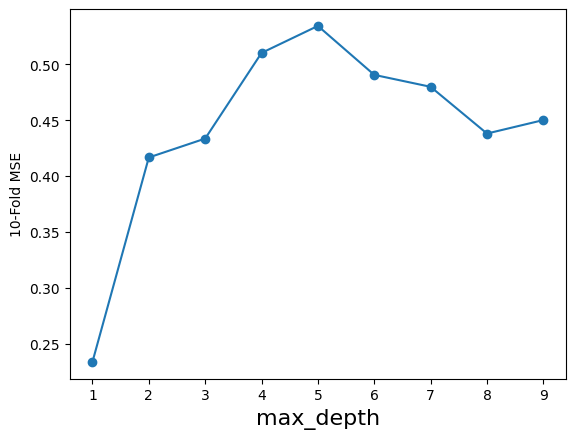

Train:  0.6538836739277332
Test:  0.5287761969783178


In [71]:
if ENVIRONMENT == 'train':
    maxDepth = range(1,10)
    param_grid = {'max_depth': maxDepth }
    grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 10, verbose=1)
    grid.fit(XtrainScaled, y_train)

    print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
    print("best parameters: {}".format(grid.best_params_))

    scores = np.array(grid.cv_results_['mean_test_score'])
    plt.plot(maxDepth,scores,'-o')
    plt.xlabel('max_depth',fontsize=16)
    plt.ylabel('10-Fold MSE')
    plt.show()

    maxDepthOptimo = grid.best_params_['max_depth'] # son 11
    treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(X_train,y_train)

    print("Train: ",treeModel.score(X_train,y_train))
    print("Test: ",treeModel.score(X_test,y_test))

### 4.3.- Evaluación.

Probando con el subconjunto de test obtenido de la validacion cruzada.

In [72]:
if ENVIRONMENT == "train":
    print("Test: ",treeModel.score(X_test,y_test))
    predictions = treeModel.predict(X_test)

Test:  0.5287761969783178


Modificado la constante declarada arriba (Indicado en rojo), ENVIRONMENT por "test", se lanza todo el estudio sobre los datos de test.
    

In [73]:
if ENVIRONMENT == "test":
    print("Test: ",treeModel.score(X,y))
    predictions = treeModel.predict(X)

In [74]:
# Calculo del error cometido
resultado = abs(y - predictions)
resultado.mean()

43.784350077863934

## 5.- Conclusión

Los resultados obtenidos no son nada buenos, habría que revisar con otros modelos distintos a los utilizados en este estudio. En el caso de obtener unos resultados similares, se tendría que revisar a ver si se han eliminado columnas significativas o bien intentar generar alguna variable nueva que mejore el modelo.

Por otro lado la calidad de los datos puede que este afectando ya que faltan bastantes valores en columnas que podrían ser relevantes como por ejemplo "Square Feet", "Week Price" o "Monthly Price".